In [1]:
import numpy as np
import scipy.signal as signal
from  matplotlib import pyplot as plt
import librosa
from IPython.display import Audio

%matplotlib inline

In [2]:
# piano tone from https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html
# simple piano tone to analyze
Fs = 11025
sig, Fs = librosa.load('piano.wav', sr=Fs)
Audio(data=sig, rate=Fs)


Text(0.5, 1.0, 'Piano tone')

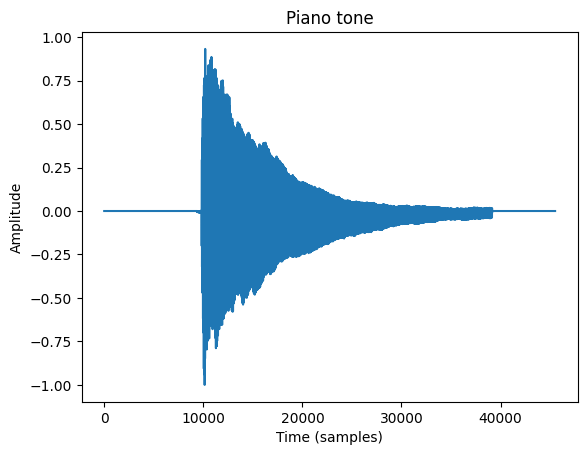

In [3]:
# Visualize in time domain
plt.plot(sig)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Piano tone')

The Fourier Transform can decompose the tone into frequencies. However, it does not indicate when does frequencies occured. In musical terms, all the notes appear at once. The short time Fourier Transform is able to indicate when the frequencies occur. It divides the signal into shorter segments and does a Fourier Transform on each one. The Scipy Python Module provides a convenient function to compute the stft (and spectrogram).

Text(0.5, 1.0, 'STFT of piano tone')

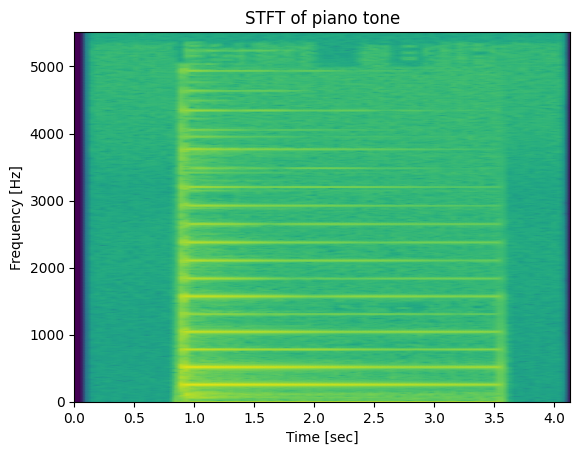

In [4]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html

#f, t, Sxx = signal.spectrogram(sig, Fs,nperseg=1024)
f, t, Sxx = signal.stft(sig, Fs,nperseg=1024)
Sxx = np.abs(Sxx)
eps = np.finfo(float).eps
Sxx = 10 * np.log10(Sxx + eps)
plt.pcolormesh(t, f, Sxx, shading='gouraud',vmax=np.max(Sxx)/10)
#plt.imshow(Sxx, aspect='auto', origin='lower',cmap='gray_r',extent=[t.min(), t.max(), f.min(), f.max()])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("STFT of piano tone")

# The STFT shows the tone is made of many frequencies, some of which persist for the duration of the tone, and some of which are transient.

It is useful to learn to compute the steps individually. The STFT first breaks-up the signal into a series of overlapping windows. Each window has 'nperseg' points. This is the same parameter that is used in the signal.stft command. A simple way of doing this is with the numpy command sliding_window_view. Although the documentation states it may not be optimal for some situations, it is useful in this case to vectorize the code.

In [5]:
# from https://numpy.org/devdocs/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html

from numpy.lib.stride_tricks import sliding_window_view

# Example from docs
x = np.arange(6)
print(x)
v = sliding_window_view(x, 3)   # 3 is the window size. Overlap is one
print()
print(v)
# to make a different overlap
v = sliding_window_view(x, 3)[::2,:]   # 3 is the window size. Overlap is two
print()
print(v)

[0 1 2 3 4 5]

[[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]]

[[0 1 2]
 [2 3 4]]


In [6]:
# Going back to the piano tone. The default overlap in scipy.signal.stft is 50% of the window size or nperseg//2
N = len(sig)
nperseg = 1024
Nw = int(2*N/nperseg) # expected number of windows
print("Expected number of Windows ",Nw)
nperseg = 1024
noverlap = int(nperseg//2)

sigO = sliding_window_view(sig, nperseg)[::noverlap,:]
print(sigO.shape)

Expected number of Windows  88
(87, 1024)


As the shape shows, each window is along a row. The next step is to multiply each window by a smoothing window to avoid leakage. STFT uses the 'hann' window but other windows could be ussed.

Text(0.5, 1.0, 'Smoothing window')

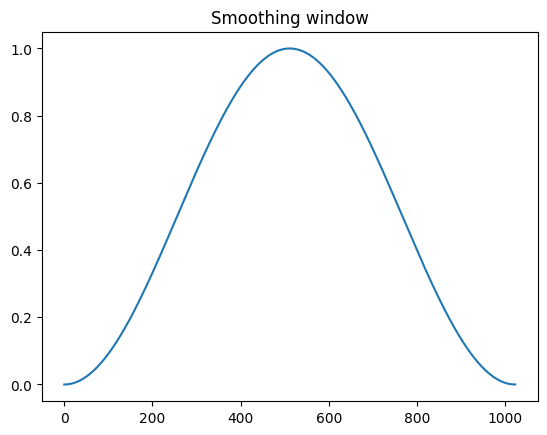

In [7]:
smoothing_window = signal.windows.hann(nperseg)
plt.plot(smoothing_window)
plt.title("Smoothing window")

In [8]:
# Apply smoothing window via matrix multiplication

sigO = np.multiply(sigO,smoothing_window)
print(sigO.shape)

(87, 1024)


(87, 513)
90 513


Text(0.5, 1.0, 'STFT of piano tone')

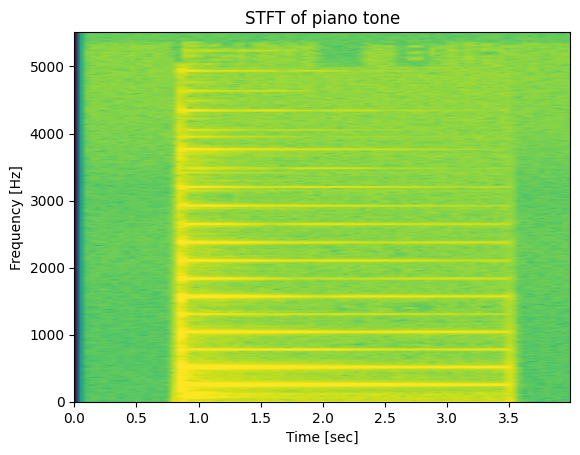

In [9]:
# Finally apply the FFT to each window to get the STFT.

sig_stft = np.fft.fft(sigO,axis=1)       # applies FFT to each row
sig_stft = np.abs(sig_stft)              # take magnitude
sig_stft = sig_stft[:,:nperseg//2+1]     # keep only positive frequencies
sig_stft = 10 * np.log10(sig_stft + eps) # convert to dB
print(sig_stft.shape)
print(len(t),len(f))                     # compared to scipy.signal.stft, there are slightly fewer windows. This might result from different padding at the ends
#plt.imshow(sig_stft.T, aspect='auto', origin='lower') # ,cmap='gray_r',extent=[t.min(), t.max(), f.min(), f.max()])
sr,sc = sig_stft.shape
t2 = t[:sr]

plt.pcolormesh(t2, f, sig_stft.T, shading='gouraud',vmax=np.max(sig_stft)/10)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("STFT of piano tone")

plt.title("STFT of piano tone")

The STFT can also be computed in parallel using the Python futures library. Although its not faster in this example, the module can prove useful for longer sequences.
    

5688
8 5688
(80, 513)
90 513


Text(0.5, 1.0, 'STFT of piano tone')

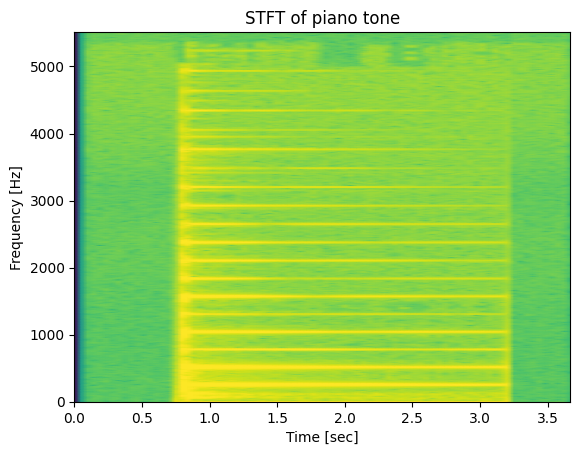

In [18]:
from concurrent import futures
import itertools
import os
import tf_functions as tf


def get_mystft(sig_list,nperseg,workers=1):
    
   
    with futures.ProcessPoolExecutor(workers) as executor:
        results = executor.map(tf.get_stft, sig_list, itertools.repeat(nperseg))
    
    stft_list = []
    for result in results:
        stft_list.append(result)
    stft = stft_list[0]
    for i in range(1,len(stft_list)):
        stft = np.concatenate((stft,stft_list[i]),axis=0)
    return stft
   
workers = os.cpu_count()
 
segment_len = int(N/workers)
print(segment_len  )
sig_list = []
for i in range(workers):
    sig_list.append(sig[i*segment_len:(i+1)*segment_len])
print(len(sig_list),len(sig_list[2]))
my_stftp = get_mystft(sig_list,nperseg,workers=workers)

sig_stft = 10 * np.log10(my_stftp + eps) # convert to dB
print(sig_stft.shape)
print(len(t),len(f))                     # compared to scipy.signal.stft, there are slightly fewer windows. This might result from different padding at the ends
#plt.imshow(sig_stft.T, aspect='auto', origin='lower') # ,cmap='gray_r',extent=[t.min(), t.max(), f.min(), f.max()])
sr,sc = sig_stft.shape
t2 = t[:sr]

plt.pcolormesh(t2, f, sig_stft.T, shading='gouraud',vmax=np.max(sig_stft)/10)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("STFT of piano tone")
